Authors: Phil Xie and Abhinav Gundrala.

Modified from:
Abibullaev et al. A Systematic Deep Learning Model Selection for P300-Based Brain–Computer Interfaces. IEEE Transactions on Systems, Man, and Cybernetics: Systems, Vol. 52, No. 5, May 2022.
https://github.com/berdakh/P3Net


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import itertools
import numpy as np
import pandas as pd
import pickle
import time
import mne
from pathlib import Path
import copy
# %%


# Define Classes/Functions

In [20]:
class CNN2D(torch.nn.Module):
    """ Flexible 2D CNN 
    Example Usage:
        from nu_models import CNN_2DMod
        model = CNN_2DMod(kernel_size = [3, 3, 3, 3] , conv_channels = [1, 8, 16, 32])    
    """

    def __init__(self,
                 input_size,  # (1, 16, 76),
                 kernel_size=[3, 3],
                 conv_channels=[1, 8],
                 dense_size=256,
                 dropout=0.1):

        super(CNN2D, self).__init__()
        self.cconv = []
        self.MaxPool = nn.MaxPool2d((1, 16), (1, 16))
        self.ReLU = nn.ReLU()
        self.Dropout = nn.Dropout(dropout)
        self.batchnorm = []

        for jj in conv_channels:
            self.batchnorm.append(nn.BatchNorm2d(jj))
        ii = 0
        # define CONV layer architecture:
        for in_channels, out_channels in zip(conv_channels, conv_channels[1:]):
            conv_i = torch.nn.Conv2d(in_channels=in_channels,
                                     out_channels=out_channels,
                                     kernel_size=kernel_size[ii],
                                     padding=kernel_size[ii]//2)
            self.cconv.append(conv_i)
            self.add_module('CNN_K{}_O{}'.format(
                kernel_size[ii], out_channels), conv_i)
            ii += 1

        self.flat_fts = self.get_output_dim(input_size, self.cconv)
        self.fc1 = torch.nn.Linear(self.flat_fts, dense_size)
        self.fc2 = torch.nn.Linear(dense_size, 2)
        self.sft_max = torch.nn.Softmax(2)

    def get_output_dim(self, in_size, cconv):
        with torch.no_grad():
            input = torch.autograd.Variable(torch.ones(1, *in_size))
            for conv_i in self.cconv:
                input = conv_i(input)
                input = self.MaxPool(input)
                print('>>> Conv Output >>>', input.shape)
                flatout = int(np.prod(input.size()[1:]))

            print("Flattened output ::", flatout)
        return flatout

    def forward(self, input):
        for jj, conv_i in enumerate(self.cconv):
            input = conv_i(input)
            input = self.batchnorm[jj+1](input)
            input = self.ReLU(input)
            input = self.MaxPool(input)

        # flatten the CNN output
        out = input.view(-1, self.flat_fts)
        out = self.ReLU(self.fc1(out))
        out = self.Dropout(out)
        out = self.fc2(out)
        out = self.sft_max(out)
        return out

In [21]:
class getTorch(object):
    def __init__(self):
        pass

    @staticmethod
    def get_data(data, batch_size, lstm, image, raw):
        """ This function takes data that is obtained from sklearn 
        train_test_split and wraps with pytorch dataloaders            

        Input: 
            data : is dictionary with the following structure        
                  dict_keys(['xtrain', 'xvalid', 'xtest', 'ytrain', 'yvalid', 'ytest'])
            where:                 
            *xtrain, xvalid, xtest : [trials x channels x time_samples] is ndarray         
            *labels: 'ytrain', 'yvalid', 'ytest'

        Output: 
            pytorch dataloader dictionary object with  [xtrain, xvalid, xtest]

        Options:
            if LSTM = TRUE,  data will be reshaped to be used with LSTM             
            if IMAGE = TRUE then data is reshaped as an gray scale image 
            if RAW = TRUE,  the original data is returned without reshaping             
        """

        # Input data is a dictionary
        x_train, y_train = data['xtrain'], data['ytrain']
        x_valid, y_valid = data['xvalid'], data['yvalid']
        x_test,  y_test = data['xtest'],  data['ytest']

        if lstm:  # re-arranges the data to use with LSTM
            x_train = x_train.permute(0, 2, 1)
            x_valid = x_valid.permute(0, 2, 1)
            x_test = x_test.permute(0, 2, 1)

        if image:  # this option will reshape the input as a gray scale image
            x_train = torch.unsqueeze(x_train, dim=1)
            x_valid = torch.unsqueeze(x_valid, dim=1)
            x_test = torch.unsqueeze(x_test, dim=1)

        print('Input data shape', x_train.shape)
        ##############################################
        # TensorDataset
        train_dat = TensorDataset(x_train, y_train)
        val_dat = TensorDataset(x_valid, y_valid)

        ##############################################
        train_loader = DataLoader(
            train_dat, batch_size=batch_size, shuffle=True, drop_last=False)
        val_loader = DataLoader(
            val_dat,   batch_size=batch_size, shuffle=False, drop_last=False)

        if raw:  # get the raw inputs (no TensorDataset nor DataLoader used)
            out = dict(train_input=x_train,
                       x_valid=x_valid,
                       train_target=y_train,
                       y_valid=y_valid,
                       test_data={'x_test': x_test, 'y_test': y_test})

        else:  # return data loaders
            out = dict(dset_loaders={'train': train_loader, 'val': val_loader},
                       dset_sizes={'train': len(x_train), 'val': len(x_valid)},
                       test_data={'x_test': x_test, 'y_test': y_test})
        return out

In [29]:
class EEGDataLoader(object):
    def __init__(self, epochs, target='target', nontarget='non-target'):
        self.epochs = epochs
        self.target_label = target
        self.nontarget_label = nontarget

    def load_data(self):
        """Loads all the data from the EEG dataset.              
        returns dictionary of:
            X_train: np.array of shape (samples, channel, times), data features
            y_train: np.array of shape (samples), data labels

            X_valid: np.array of shape (samples, channel, times), data features
            y_valid: np.array of shape (samples), data labels

            X_test: np.array of shape (samples, channel, times), testing features
            y_test np.array of shpe (samples), testing labels
        """

        X = self.epochs.get_data(picks=['eeg'])# 
        Y = self.epochs.events[:, -1] - 1
        
        x_rest, x_test, y_rest, y_test =\
            train_test_split(X, Y, test_size=0.50, random_state=42, stratify=Y)

        x_train, x_valid, y_train, y_valid =\
            train_test_split(x_rest, y_rest, test_size=0.20,
                             random_state=42, stratify=y_rest)

# %%     UPSAMPLING after split / x_test is left out without upsampling
        upTrain = len(y_train[y_train == 0])//len(y_train[y_train == 1])
        ptrain = x_train[y_train == 1, :, :]
        pvalid = x_valid[y_valid == 1, :, :]

        for j in range(upTrain-1):  # create multiple copies of target ERPs
            ptrain = np.concatenate([ptrain, x_train[y_train == 1, :, :]])
            pvalid = np.concatenate([pvalid, x_valid[y_valid == 1, :, :]])

        # upsampled xtrain
        x_train = np.concatenate([x_train, ptrain])
        y_train = np.concatenate([y_train, np.ones(ptrain.shape[0])])

        # upsampled xvalid
        x_valid = np.concatenate([x_valid, pvalid])
        y_valid = np.concatenate([y_valid, np.ones(pvalid.shape[0])])

        # Convert to Pytorch tensors
        X_train, X_valid, X_test = map(
            torch.FloatTensor, (x_train, x_valid, x_test))
        y_train, y_valid, y_test = map(
            torch.LongTensor,  (y_train, y_valid, y_test))

        return dict(xtrain=X_train, xvalid=X_valid, xtest=X_test,
                    ytrain=y_train, yvalid=y_valid, ytest=y_test)

In [30]:
def train_model(model, dset_loaders, dset_sizes, criterion, optimizer, dev,
                lr_scheduler=None, num_epochs=50, verbose=2):
    """
    Method to train a PyTorch neural network with the given parameters for a
    certain number of epochs. Keeps track of the model yielding the best validation
    accuracy during training and returns that model before potential overfitting
    starts happening. Records and returns training and validation losses and accuracies over all
    epochs.

    Args:
        model (torch.nn.Module): The neural network model that should be trained.

        dset_loaders (dict[string, DataLoader]): Dictionary containing the training
            loader and test loader: {'train': trainloader, 'val': testloader}
        dset_sizes (dict[string, int]): Dictionary containing the size of the training
            and testing sets. {'train': train_set_size, 'val': test_set_size}

        criterion (PyTorch criterion): PyTorch criterion (e.g. CrossEntropyLoss)
        optimizer (PyTorch optimizer): PyTorch optimizer (e.g. Adam)

        lr_scheduler (PyTorch learning rate scheduler, optional): PyTorch learning rate scheduler
        num_epochs (int): Number of epochs to train for
        verbose (int): Verbosity level. 0 for none, 1 for small and 2 for heavy printouts
    """

    start_time = time.time()
    best_model, best_acc = model, 0.0

    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    train_labels, val_labels = [], []

    for epoch in range(num_epochs):
        if verbose > 1:
            print('Epoch {}/{}'.format(epoch+1, num_epochs))
        ypred_labels, ytrue_labels = [], []

        if best_acc > 0.97:
            break

        # there are two phases [Train and Validation]
        for phase in ['train', 'val']:
            if phase == 'train':
                if lr_scheduler:
                    optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
            running_loss, running_corrects = 0.0, 0.0
            # Iterate over mini-batches
            batch = 0
            for data in dset_loaders[phase]:
                input, label = data
                inputs = input.to(dev)
                labels = label.to(dev)
                #print("DEBUG", labels)
                optimizer.zero_grad()
                
                # Phil commented out the above block, since we're not using LSTM
                preds = model(inputs)
                # Calculate the loss
                loss = criterion(preds, labels)
                # Backpropagate & weight update
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                # store batch performance
                running_loss += loss.item()
                preds_classes = preds.data.max(1)[1]
                running_corrects += torch.sum(preds_classes == labels.data)

                ytrue_labels.append(labels.data.cpu().detach().numpy())
                ypred_labels.append(preds_classes.cpu().detach().numpy())

                batch += 1

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects.cpu().numpy()/dset_sizes[phase]

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
                train_labels.append(
                    dict(ypred=ypred_labels, ytrue=ytrue_labels))

            else:  # val
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)
                val_labels.append(dict(ypred=ypred_labels, ytrue=ytrue_labels))

            if verbose > 1:
                print('{} loss: {:.4f}, acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
            # Deep copy the best model using early stopping
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                best_model = copy.deepcopy(model)

        

    time_elapsed = time.time() - start_time

    # ytrue and ypred from the best model during the training
    def best_epoch_labels(train_labels, best_epoch):
        for jj in range(len(train_labels[best_epoch]['ypred'])-1):
            if jj == 0:
                ypred = train_labels[best_epoch]['ypred'][jj]
                ytrue = train_labels[best_epoch]['ytrue'][jj]
            ypred = np.concatenate(
                [ypred, train_labels[best_epoch]['ypred'][jj+1]])
            ytrue = np.concatenate(
                [ytrue, train_labels[best_epoch]['ytrue'][jj+1]])
        return ypred, ytrue

    ytrain_best = best_epoch_labels(train_labels, best_epoch)
    yval_best = best_epoch_labels(val_labels, best_epoch)

    info = dict(ytrain=ytrain_best, yval=yval_best,
                best_epoch=best_epoch, best_acc=best_acc)

    if verbose > 0:
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))
        print('Best Epoch :', best_epoch+1)
    return best_model, train_losses, val_losses, train_accs, val_accs, info

# Load Raw

In [7]:

# set directories
path_to_eegnb = "C:/Users/abhin/" #{PUT HERE}
filename = "data_2017-02-09-17.30.02"
save_dir = "./data/{name}.pickle".format(name=filename)
in_dir = path_to_eegnb + "eegnb/data/visual-P300/eegnb_examples/muse2016/subject0001/session002/{name}.csv".format(name=filename)

csv_folder = Path(path_to_eegnb + 'eegnb/data/visual-P300/eegnb_examples/muse2016')  # path to your folder, e.g. to `2022`
# make raw array for each file
raws = []
for p in csv_folder.glob('*/*/*.csv'):
    df = pd.read_csv(p)
    for mark_chan in ['Marker0', 'Marker']:
        if mark_chan in df:
            df['markers'] = df[mark_chan].astype('int')
            df = df.drop(columns=[mark_chan, 'timestamps', 'Right AUX'])
            
            data = df.to_numpy().T
            data[:-1] = data[:-1] * 1e-6 # convert to V
            ch_types = ['eeg'] * 4 + ['stim']

            empty_info = mne.create_info(ch_types=ch_types, ch_names=['TP9', 'Fp1', 'Fp2', 'TP10', 'mark'], sfreq=256)
            raw = mne.io.RawArray(data, empty_info, first_samp=0, copy='auto', verbose=None)
            raw.filter(1,30, method='iir')

            raws.append(raw)
            print(len(raws), raw)

Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

1 <RawArray | 5 x 30732 (120.0 s), ~1.2 MB, data loaded>
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

2 <RawArray | 5 x 30732 (120.0 s), ~1.2 MB, data loaded>
Crea

Using matplotlib as 2D backend.


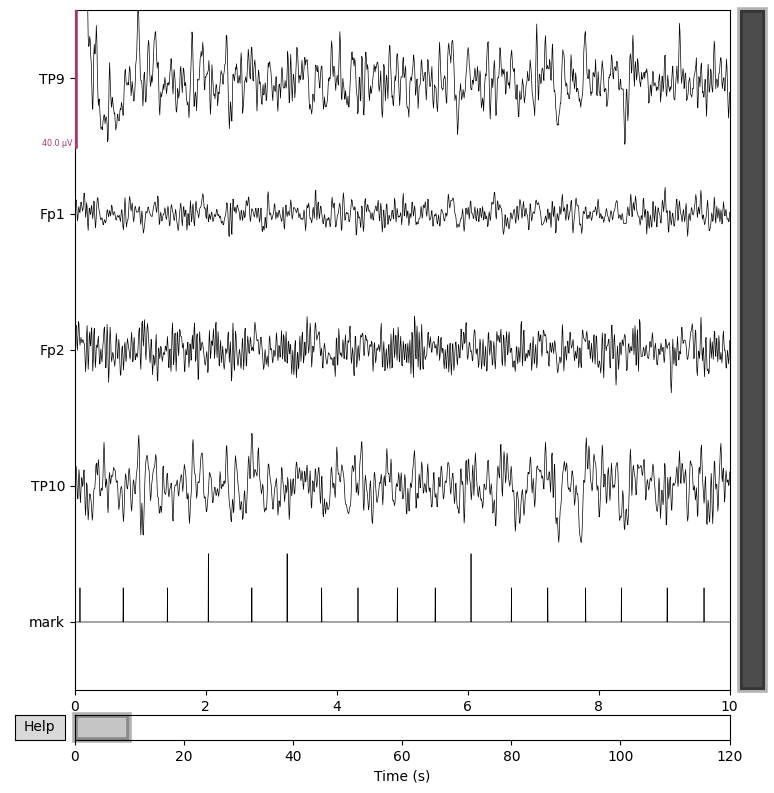

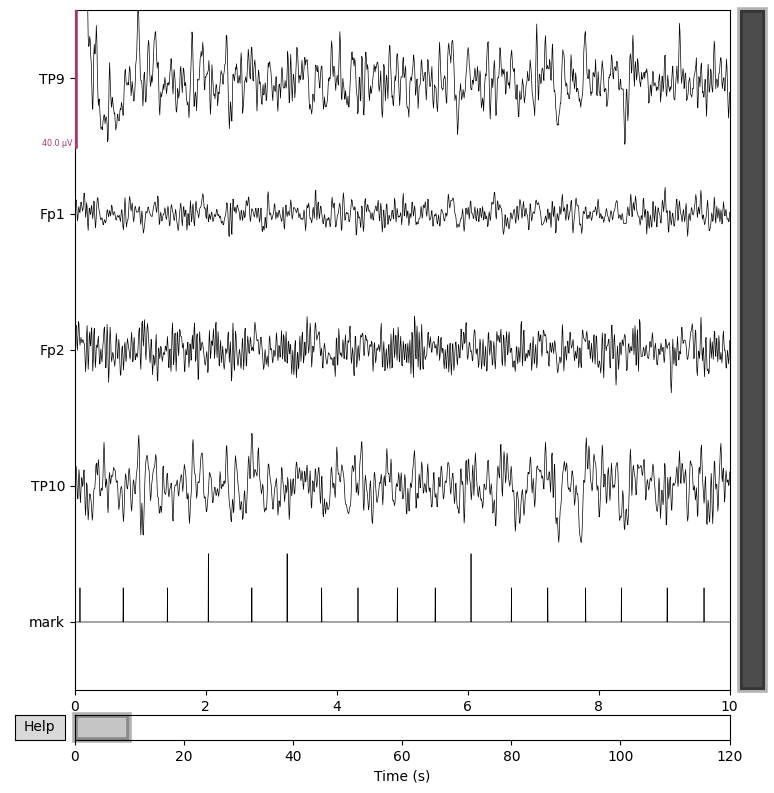

In [8]:
raws[0].plot()

Effective window size : 1.000 (s)


C:\Users\abhin\AppData\Local\Temp\ipykernel_23664\803640377.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raws[0].compute_psd().plot()
c:\Users\abhin\Projects\neurotech\focus_pocus\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


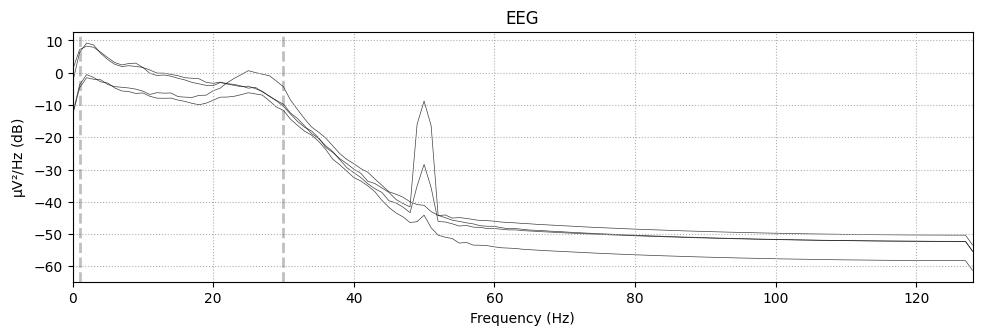

In [9]:
raws[0].compute_psd().plot()

197 events found
Event IDs: [1 2]


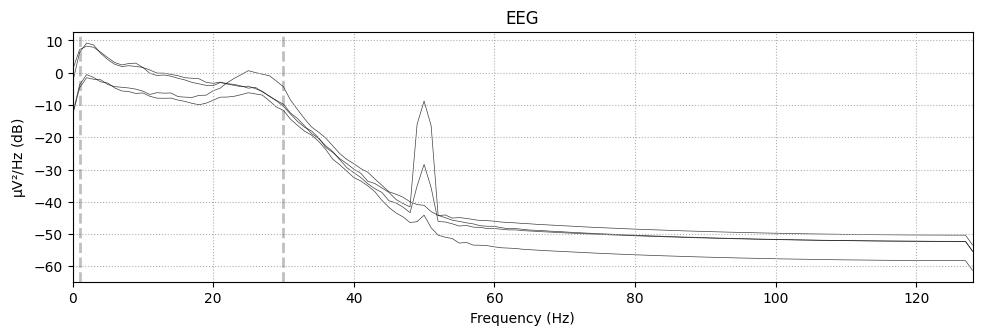

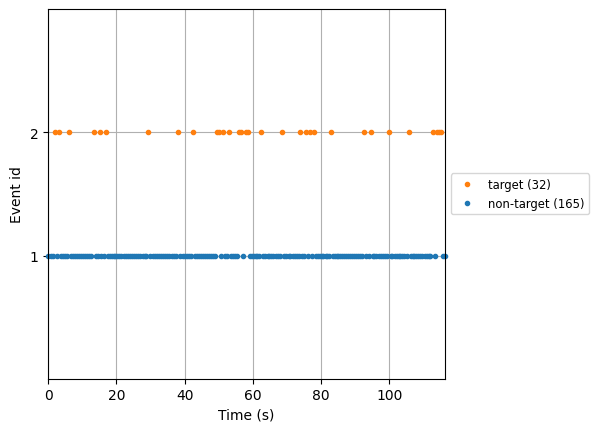

In [10]:
event_dict = {'target' : 2, 'non-target' : 1}
events = mne.find_events(raws[0], stim_channel=['mark'])
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp)

In [11]:
epochs = mne.Epochs(raws[0], events, event_id=event_dict, tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 100e-6}, preload=True)

Not setting metadata
197 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 197 events and 232 original time points ...
    Rejecting  epoch based on EEG : ['TP9', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'TP10']
3 bad epochs dropped


197 events found
Event IDs: [1 2]
Not setting metadata
197 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 197 events and 232 original time points ...
    Rejecting  epoch based on EEG : ['TP9', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'TP10']
3 bad epochs dropped
191 events found
Event IDs: [1 2]
Not setting metadata
191 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 191 events and 232 original time points ...
    Rejecting  epoch based on EEG : ['TP9', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'TP10']
4 bad epochs dropped
193 events found
Event IDs: [1 2]
Not setting metadata
193 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 193 events and 232 original time 

C:\Users\abhin\AppData\Local\Temp\ipykernel_23664\2311949100.py:17: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  odd_epochs.plot_image(picks=['TP10', 'TP9', 'Fp1', 'Fp2'])
C:\Users\abhin\AppData\Local\Temp\ipykernel_23664\2311949100.py:17: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  odd_epochs.plot_image(picks=['TP10', 'TP9', 'Fp1', 'Fp2'])
C:\Users\abhin\AppData\Local\Temp\ipykernel_23664\2311949100.py:17: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  odd_epochs.plot_image(picks=['TP10', 'TP9', 'Fp1', 'Fp2'])
C:\Users\abhin\AppData\Local\Temp\ipykernel_23664\2311949100.py:17: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  odd_epochs.plot_image(picks=['TP10', 'TP9', 'Fp1', 'Fp2'])


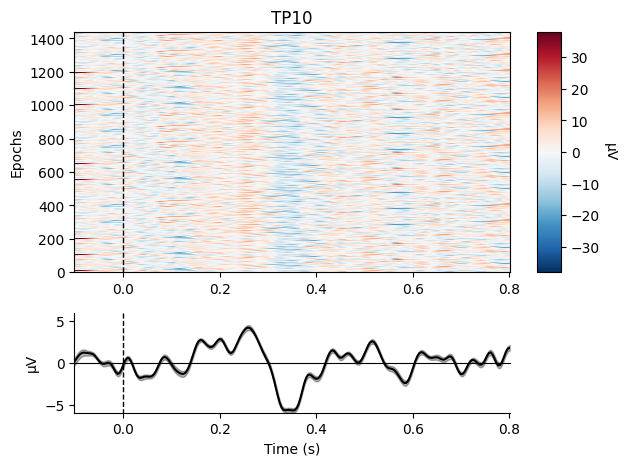

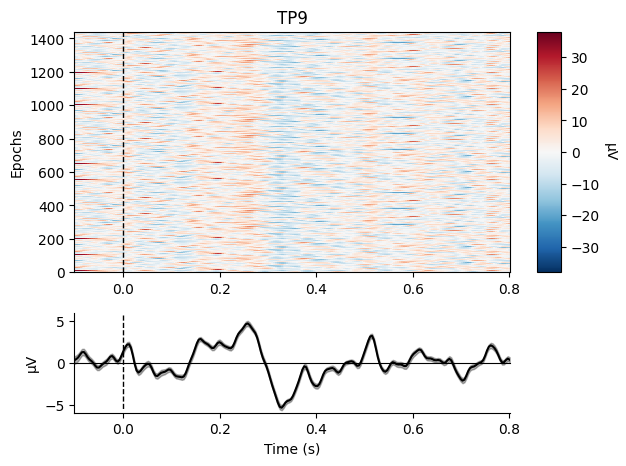

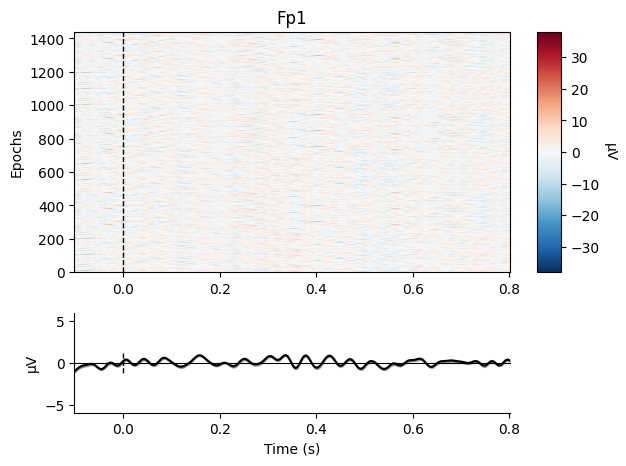

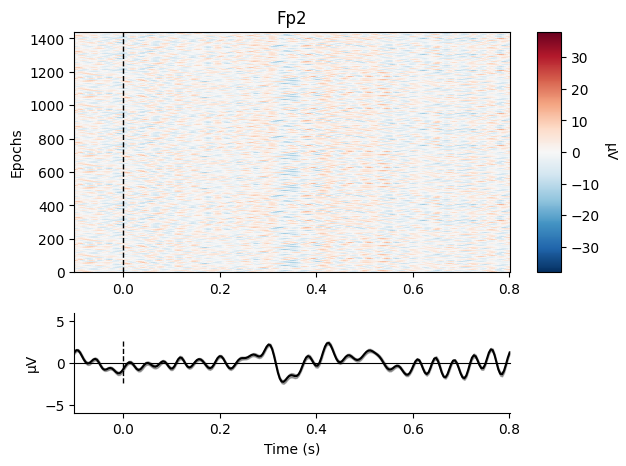

Not setting metadata
7290 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
7290 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
7290 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
7290 matching events found
No baseline correction applied
0 projection items activated


C:\Users\abhin\AppData\Local\Temp\ipykernel_23664\2311949100.py:18: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  norm_epochs.plot_image(picks=['TP10', 'TP9', 'Fp1', 'Fp2'])
C:\Users\abhin\AppData\Local\Temp\ipykernel_23664\2311949100.py:18: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  norm_epochs.plot_image(picks=['TP10', 'TP9', 'Fp1', 'Fp2'])
C:\Users\abhin\AppData\Local\Temp\ipykernel_23664\2311949100.py:18: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  norm_epochs.plot_image(picks=['TP10', 'TP9', 'Fp1', 'Fp2'])
C:\Users\abhin\AppData\Local\Temp\ipykernel_23664\2311949100.py:18: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  norm_epochs.plot_image(picks=['TP10', 'TP9', 'Fp1', 'Fp2'])


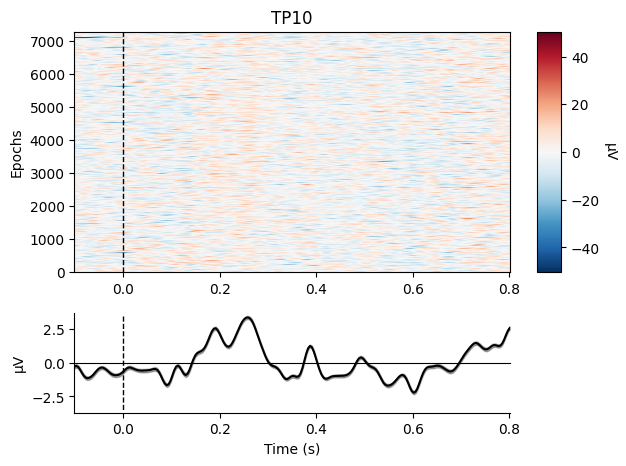

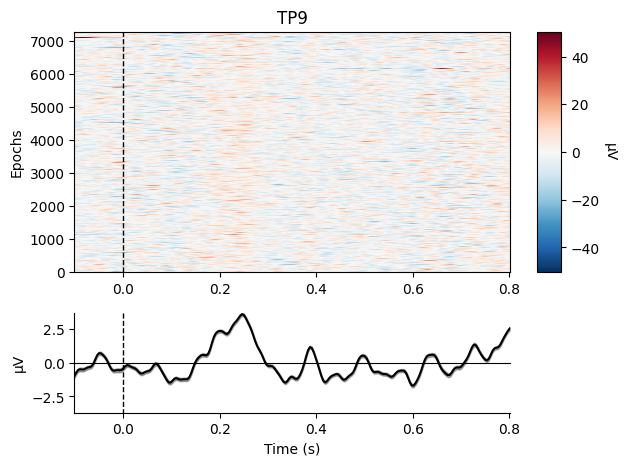

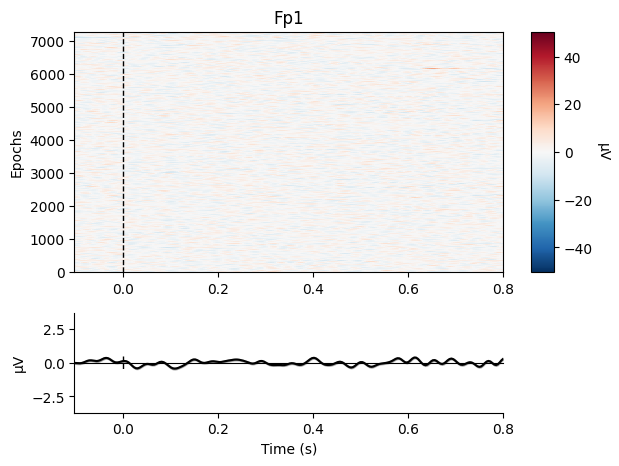

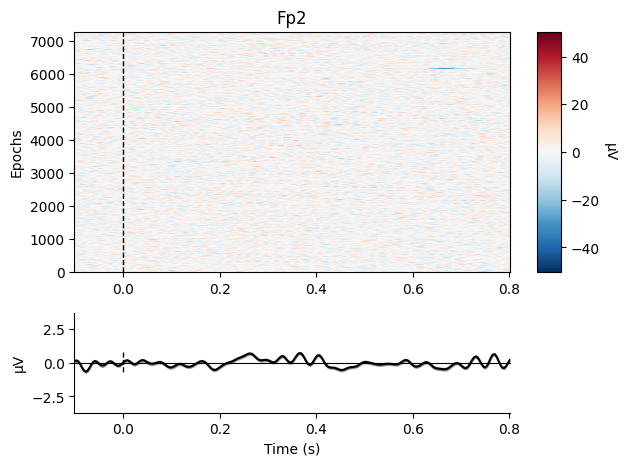

[<Figure size 640x480 with 3 Axes>,
 <Figure size 640x480 with 3 Axes>,
 <Figure size 640x480 with 3 Axes>,
 <Figure size 640x480 with 3 Axes>]

In [12]:
# calculate all epochs across subjects

event_dict = {'target' : 2, 'non-target' : 1}
epoch_lst = []
for raw in raws:
    events = mne.find_events(raw, stim_channel=['mark'])
    subj_epochs = mne.Epochs(raws[0], events, event_id=event_dict, tmin=-0.1, tmax=0.8, baseline=None,
                    reject={'eeg': 100e-6}, preload=True)
    epoch_lst.append(epochs)


epochs = mne.concatenate_epochs(epoch_lst)
odd_epochs = epochs['target']
norm_epochs = epochs['non-target']


odd_epochs.plot_image(picks=['TP10', 'TP9', 'Fp1', 'Fp2'])
norm_epochs.plot_image(picks=['TP10', 'TP9', 'Fp1', 'Fp2'])

# NN Load Data & Set Params

In [13]:
get_data = getTorch.get_data # shorthand for function
#dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dev = "cpu"
print('Your GPU device name :', torch.cuda.get_device_name())
print(dev)

Your GPU device name : NVIDIA GeForce RTX 3070 Laptop GPU
cpu


In [26]:
# %% Hyperparameter settings
num_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-4
batch_size = 64
verbose = 2

In [27]:
# %%
# one should run this script twice with ConvDown = True or False to have different convolutional layer patterns
# as defined below by params dictionary.

ConvDOWN = True   # change this option
d1 = EEGDataLoader(epochs, 'target', 'nontarget').load_data()
print(d1.keys())

dict_keys(['xtrain', 'xvalid', 'xtest', 'ytrain', 'yvalid', 'ytest'])


In [31]:
d1 = EEGDataLoader(epochs, 'target', 'nontarget').load_data()
# data dict has structure
'''
(['xtrain', 'xvalid', 'xtest', 'ytrain', 'yvalid', 'ytest'])
X_train: np.array of shape (samples, channel, times), data features
y_train: np.array of shape (samples), data labels
'''

# % identify input size (channel x timepoints)
timelength = d1['xtest'].shape[2]
chans = d1['xtest'].shape[1]
input_size = (1, chans, timelength)

# % used to save the results table
results = {}
table = pd.DataFrame(columns=['Train_Acc', 'Val_Acc', 'Test_Acc', 'Epoch'])

# get data
dset = get_data(d1, batch_size, image=True, lstm=False, raw=False)
dset_loaders = dset['dset_loaders']
dset_sizes = dset['dset_sizes']

# Define the model
model = CNN2D(input_size=input_size,
            kernel_size=[1, 8],
            conv_channels=[1, 8])

print("Model architecture >>>", model)
# optimizer and the loss function definition
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()

# move the model to GPU/CPU
model.to(dev)
criterion.to(dev)

# ******** Training loop *********
best_model, train_losses, val_losses, train_accs, val_accs, info = train_model(model, dset_loaders,
                                                                            dset_sizes, criterion, optimizer,
                                                                            dev, lr_scheduler=None, num_epochs=num_epochs,
                                                                            verbose=verbose)
# ------------------------------------------------


Input data shape torch.Size([6372, 1, 4, 232])
>>> Conv Output >>> torch.Size([1, 8, 4, 14])
Flattened output :: 448
Model architecture >>> CNN2D(
  (MaxPool): MaxPool2d(kernel_size=(1, 16), stride=(1, 16), padding=0, dilation=1, ceil_mode=False)
  (ReLU): ReLU()
  (Dropout): Dropout(p=0.1, inplace=False)
  (CNN_K1_O8): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=448, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)
Epoch 1/100
train loss: 0.0108, acc: 0.5424
val loss: 0.0108, acc: 0.5424
Epoch 2/100
train loss: 0.0106, acc: 0.5651
val loss: 0.0104, acc: 0.5424
Epoch 3/100
train loss: 0.0100, acc: 0.7068
val loss: 0.0094, acc: 0.5863
Epoch 4/100
train loss: 0.0085, acc: 0.8067
val loss: 0.0075, acc: 0.8669
Epoch 5/100
train loss: 0.0070, acc: 0.8592
val loss: 0.0062, acc: 0.8933
Epoch 6/100
train loss: 0.0059, acc: 0.8832
val loss: 0.0053, acc: 0.9215
Epoch 7/100
train loss: 0.0051, acc: 0.8916
val loss: 0.0047, 

# Main Loop

In [ ]:

x_test = torch.reshape(d1['xtest'], (1746, 1, 4, 232))
y_test = d1['ytest']
# ************************

preds = best_model(x_test.to(dev))
print(preds)
preds_class = preds.data.max(1)[1]

# accuracy
corrects = torch.sum(preds_class == y_test.data.to(dev))
test_acc = corrects.cpu().numpy()/x_test.shape[0]
print("Test Accuracy :", test_acc)

In [ ]:
fname = 'trained_model.pt'
torch.save(best_model.state_dict(), fname)